### 分析資料：Technology Equity ETF List
#### 目標 : 爬蟲取得ETF相關資料、視覺化、分析比較  

程式整體架構  
> 利用野村證券提供的資料集(選定其中Equity類別的科技類股)抽取出欲分析的ETF  

> 到財經相關網站爬取收盤價、本益比、報酬率等資料  

> 將資料存取並視覺化、繪圖觀察ETF績效  

> 進一步分析、解釋問題  

> 試著模擬投資情況  

* 目前進度  

  3/20 從網站上爬取所需資料並繪製折線圖，但過程中有一個網頁元素無法定位，因此還未寫進迴圈自動化，以下程式以XLK的資料作DEMO  
  4/4 建好函數，迴圈自動爬取所有選定ETF資料，畫出各股票收盤價走勢圖 

在指定的ETF資料中，先篩選出於2015年年底既已存在的ETF，並以此子集合重新建立一個EXCEL檔

In [50]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import xlwt
import matplotlib.pyplot as plt
import pylab as pl

etf_tech = pd.read_csv("Technology_Equity_ETF.csv") #read in the file

selected_data = etf_tech[(etf_tech['Inception'] < '2016')] #篩選發行日早於2015年底者

#etf_tech.info()
#type(etf_tech[(etf_tech['Inception'] <= '2015')])

selected_data.to_excel('sel_etf_tech.xls') #write in (and create) a new file

#check
target_etf = pd.read_excel("sel_etf_tech.xls") #selected_etf_technology
target_etf.head() 

etf_name = target_etf['Symbol']  
etf_name = etf_name.reset_index(drop=True) # reset the index cause selected_data has a discontinuous index

* selenium/website 很好用，可以模擬一般人操作網頁的情況  

使用selenium套件操控網頁，前往"英為財情"網站搜尋在整理資料中的ETF名稱 

點擊一連串按鈕並跳到搜尋結果頁面 

跳到etf搜尋結果後，設定指定日期以及點選日期間格為"每月"(one of the main reason I picked this website is that it sorts the data in month) 

爬取表格裡收盤價(第一列)的資料以及對應日期 

存進list以做進一步資料處理 

將取得資料寫入新建立的excel檔案 


In [51]:
d = xlwt.Workbook() #create new file
sheet1 = d.add_sheet(u'sheet1',cell_overwrite_ok=True) #create sheet
import time

def craw(n,c): # 爬蟲
    ETF = etf_name[n] 
    driver = webdriver.Chrome() # Create a new instance of the Chrome driver
    driver.get("https://cn.investing.com/") # go to the page
    inputElement = driver.find_element_by_xpath("//input[@placeholder='在全站搜索...']") # find the input box
    inputElement.send_keys(ETF) # type in the search

    #click the search button
    driver.find_element_by_css_selector("[class='searchGlassIcon js-magnifying-glass-icon']").click()
    driver.find_element_by_css_selector("[class='js-inner-all-results-quote-item row']").click()

    #switch to the current window
    driver.switch_to.window(driver.window_handles[-1])

    #driver.implicitly_wait(30) # waiting
    
    time.sleep(1)
    
    driver.find_element_by_link_text("历史数据").click()

    #driver2 = webdriver.Chrome()
    #driver2.get("https://cn.investing.com/etfs/spdr-select-sector---technology-historical-data")
    
    time.sleep(1)
    
    driver.find_element_by_xpath('//*[@id="data_interval"]').click()  # set time interval
    driver.find_element_by_xpath('//*[@id="data_interval"]/option[3]').click() #select mothly data

    js = "$('input[id=picker]').attr('readonly','')"  #handle hidden input
    driver.execute_script(js)

    #click the calander 
    driver.find_element_by_xpath('//*[@id="widgetFieldDateRange"]').click()
    
    time.sleep(1)
    
    #input startdate
    driver.find_element_by_id('startDate').click()
    driver.find_element_by_id('startDate').clear()
    driver.find_element_by_id('startDate').send_keys('2015/01/01')

    #input enddate
    driver.find_element_by_id('endDate').click()
    driver.find_element_by_id('endDate').clear()
    driver.find_element_by_id('endDate').send_keys('2019/03/18')

    driver.find_element_by_xpath('//*[@id="applyBtn"]').click() #enter

    #print(driver2.find_element_by_id('picker').get_attribute('value'))
    #driver.quit() #close the website

    #wait for 3 seconds to avoid "unable to locate element" error
    
    time.sleep(3)
    
    #get all the rows of table
    table_rows = driver.find_element_by_xpath('//*[@id="curr_table"]').find_elements_by_tag_name('tr')
    #get numbers of table row
    totle_rows = len(table_rows) 
    
    price_data = []
    date_data = []
    #get the price data(column1)
    for i in range(1,totle_rows):
        prixpath = '//*[@id="curr_table"]/tbody/tr[' + str(i) + ']/td[2]'
        datxpath = '//*[@id="curr_table"]/tbody/tr[' + str(i) + ']/td[1]' 
    
        pridata = driver.find_element_by_xpath(prixpath).text
        datdata = driver.find_element_by_xpath(datxpath).text
        price_data.append(pridata)
        date_data.append(datdata)
        #print(pridata,datdata)
        
    print("ETF " + str(n) + " : successfully get " + etf_name[n]+ " data!")

    #check the list
    #print(price_data,date_data)
    time.sleep(4)
    driver.quit()
    
#def savexcel(k,c): # k : to get the current ETF Symbol, c : the column to write in
    sheet1.write(0,c,"Symbol"+str(n))
    sheet1.write(0,c+1,"Date"+str(n))
    sheet1.write(0,c+2,"Price"+str(n))
    sheet1.write(1,c,etf_name[n])
    
    #write in price_data, date_data
    for i in range(totle_rows-1):
        sheet1.write(i+1,c+2,price_data[i])  
    for i in range(totle_rows-1):
        sheet1.write(i+1,c+1,date_data[i])
        
    d.save('ETF_data.xls') #save

In [55]:
for i in range(25):
    craw(i,3*i)

ETF 0 : successfully get QQQ data!
ETF 1 : successfully get XLK data!
ETF 2 : successfully get VGT data!
ETF 3 : successfully get FDN data!
ETF 4 : successfully get IYW data!
ETF 5 : successfully get IXN data!
ETF 6 : successfully get XT data!
ETF 7 : successfully get IGV data!
ETF 8 : successfully get QTEC data!
ETF 9 : successfully get FTEC data!
ETF 10 : successfully get FXL data!
ETF 11 : successfully get KWEB data!
ETF 12 : successfully get SKYY data!
ETF 13 : successfully get HACK data!
ETF 14 : successfully get RYT data!
ETF 15 : successfully get IGM data!
ETF 16 : successfully get ARKK data!
ETF 17 : successfully get ROBO data!
ETF 18 : successfully get SOXX data!
ETF 19 : successfully get SMH data!
ETF 20 : successfully get TDIV data!
ETF 21 : successfully get CIBR data!
ETF 22 : successfully get SOXL data!
ETF 23 : successfully get PNQI data!
ETF 24 : successfully get TECL data!


如果一次爬取所有數據常會有error，推測應為網路問題，為避免浪費時間(跑一次至少要20分鐘)，以及求呈現之完整性，故分兩次爬取 
一旦將資料存進excel檔案，此段程式就無重跑的必要 


In [57]:
for i in range(25,len(etf_name)): # when I want to get all the data, for some reason(maybe wifi) always get error, so I split the code
    craw(i,3*i)

ETF 25 : successfully get CQQQ data!
ETF 26 : successfully get ARKW data!
ETF 27 : successfully get XNTK data!
ETF 28 : successfully get IPAY data!
ETF 29 : successfully get EMQQ data!
ETF 30 : successfully get PSCT data!
ETF 31 : successfully get PSJ data!
ETF 32 : successfully get ROM data!
ETF 33 : successfully get XSD data!
ETF 34 : successfully get PSI data!
ETF 35 : successfully get IEUS data!
ETF 36 : successfully get SOCL data!
ETF 37 : successfully get XSW data!
ETF 38 : successfully get PTF data!
ETF 39 : successfully get SOXS data!
ETF 40 : successfully get JHMT data!
ETF 41 : successfully get ITEQ data!
ETF 42 : successfully get PXQ data!
ETF 43 : successfully get ISRA data!
ETF 44 : successfully get IGN data!
ETF 45 : successfully get USD data!
ETF 46 : successfully get TECS data!
ETF 47 : successfully get SSG data!
ETF 48 : successfully get SCID data!
ETF 49 : successfully get REW data!


將資料視覺化，畫出etf收盤價走勢圖

C:\Users\Elvish\anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


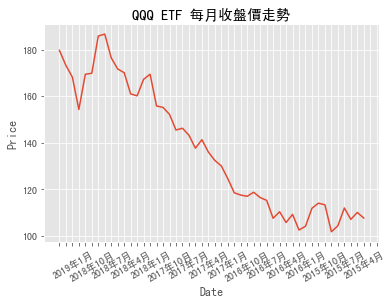

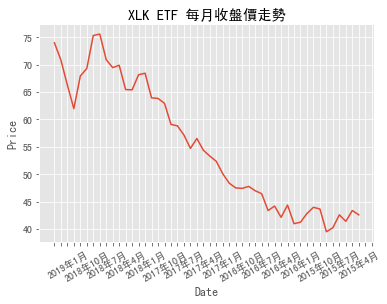

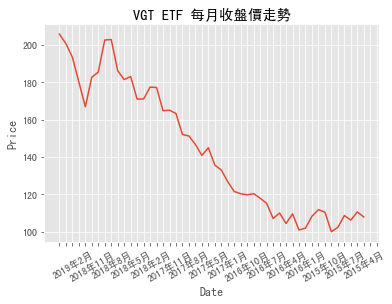

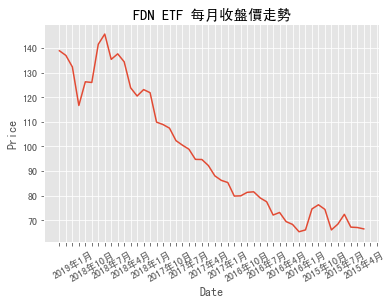

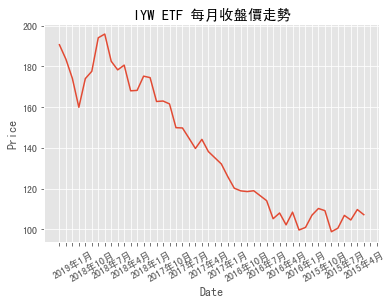

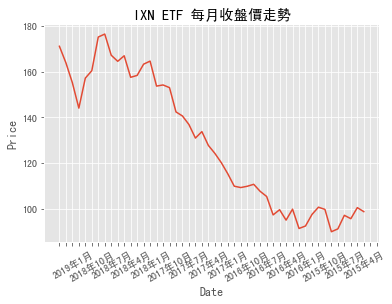

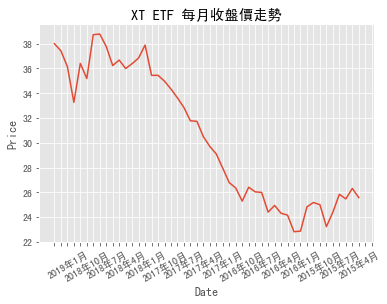

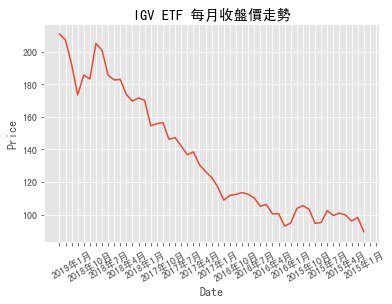

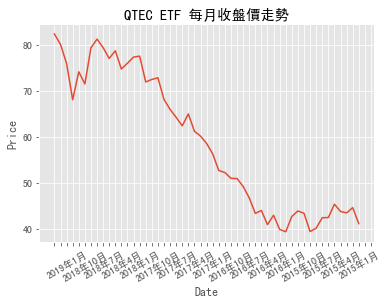

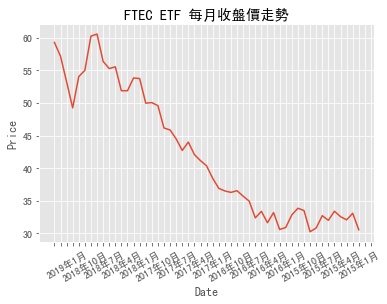

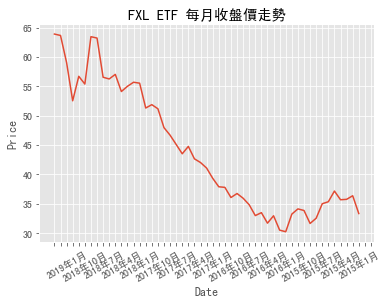

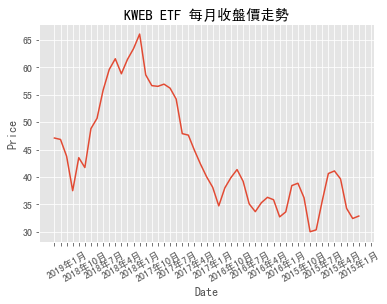

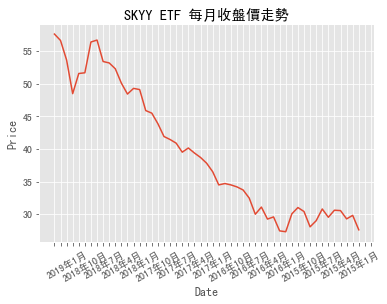

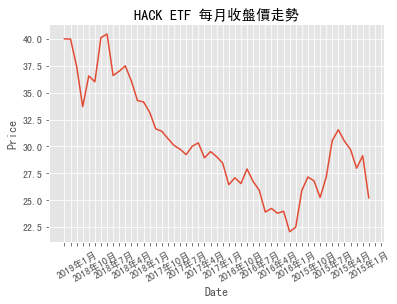

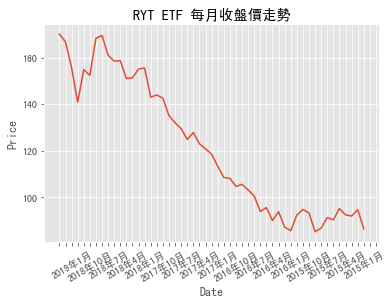

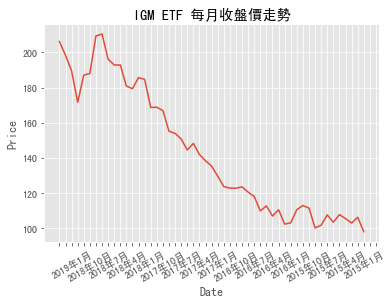

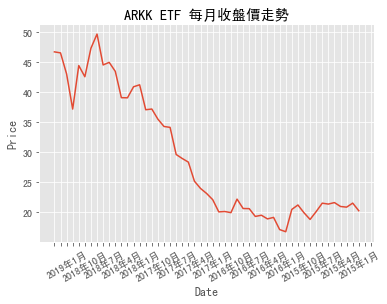

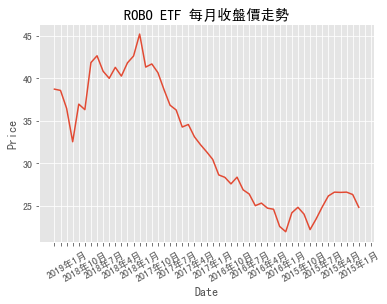

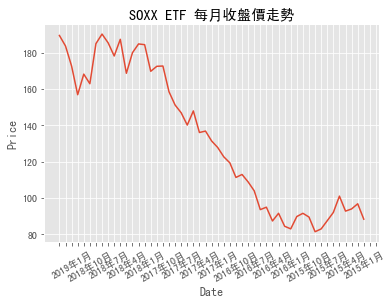

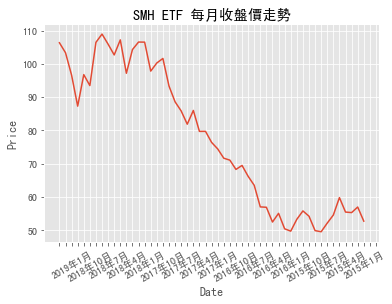

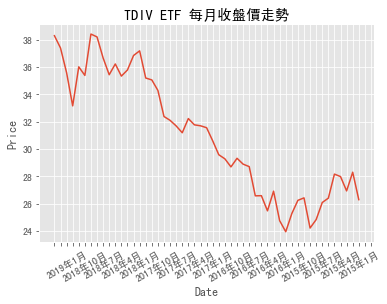

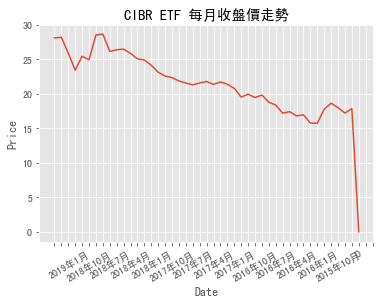

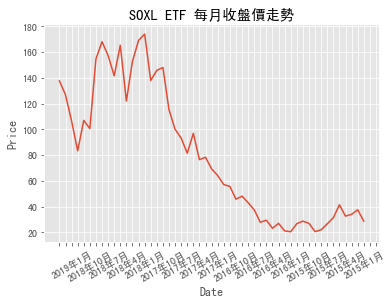

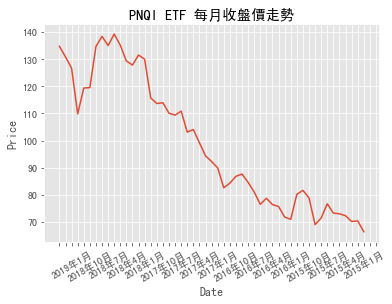

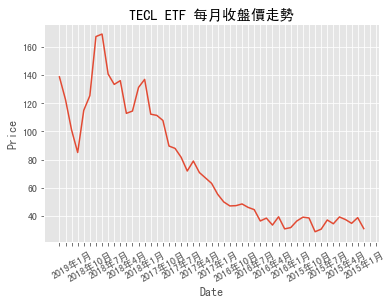

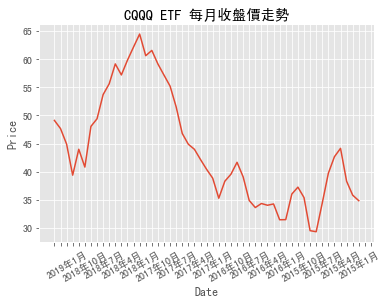

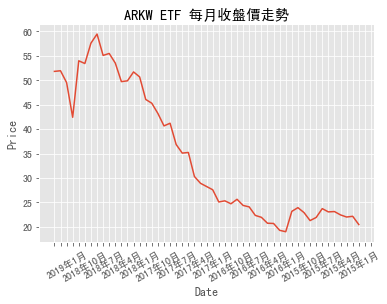

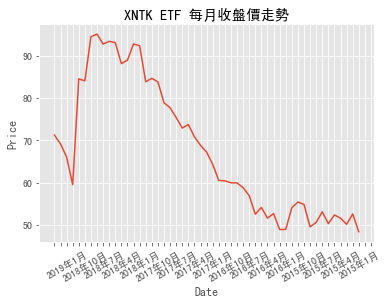

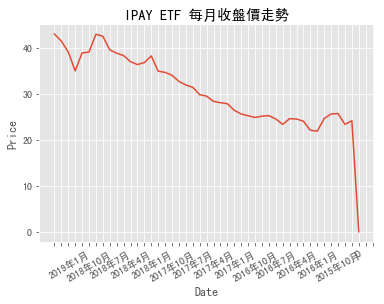

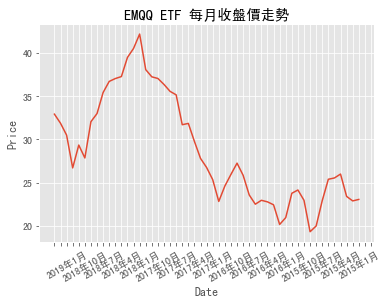

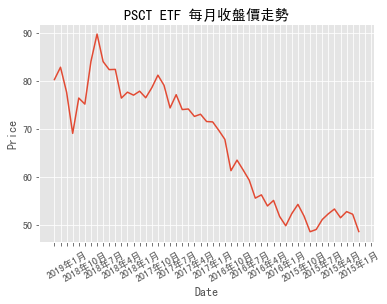

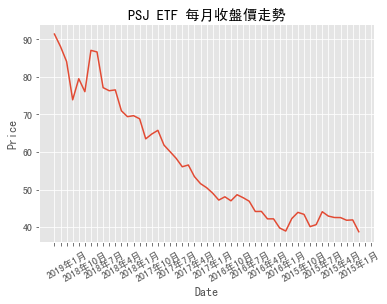

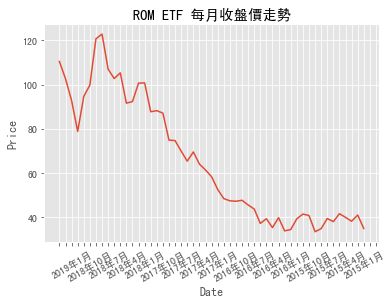

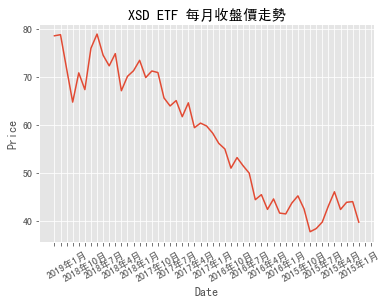

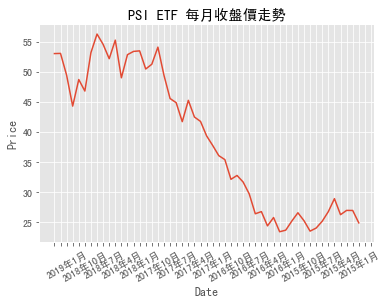

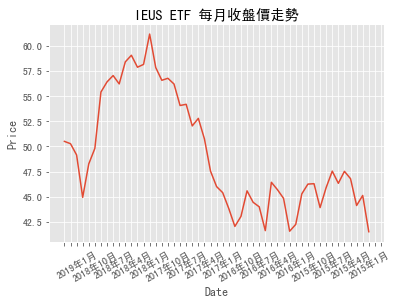

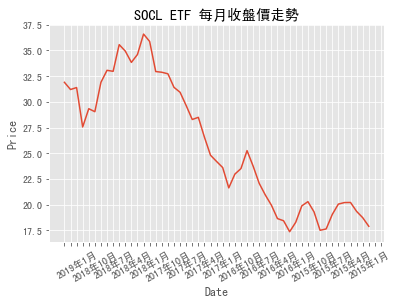

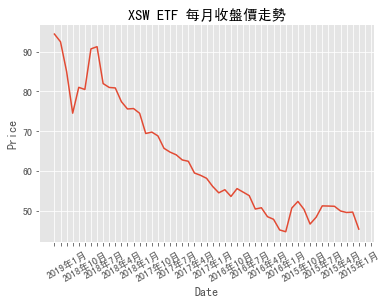

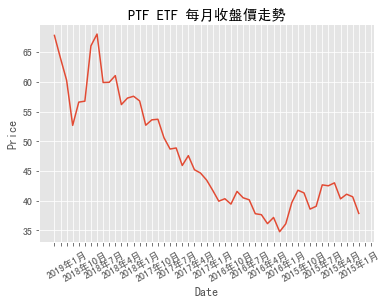

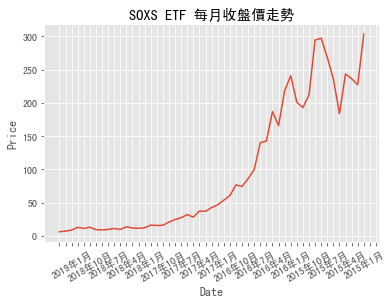

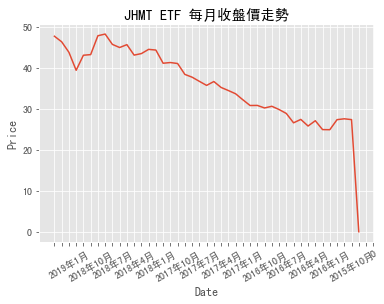

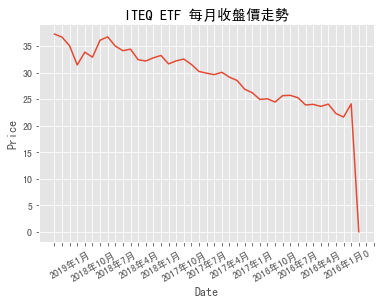

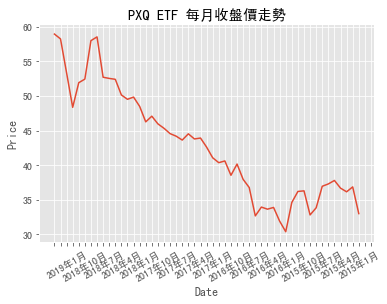

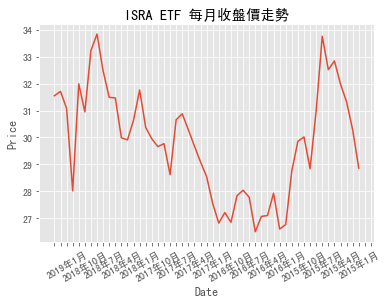

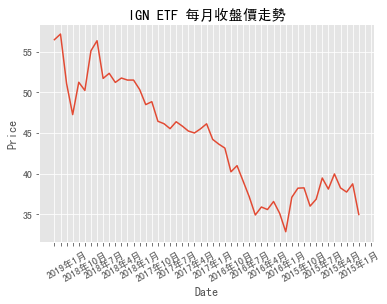

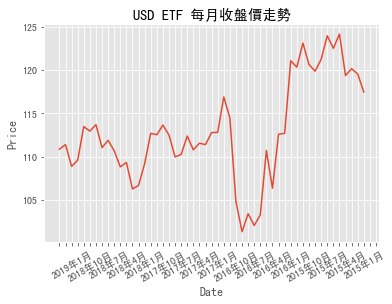

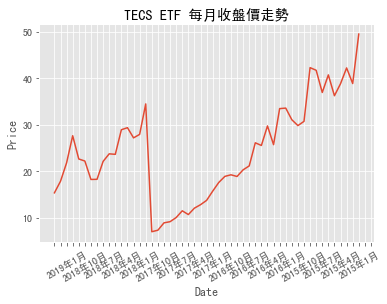

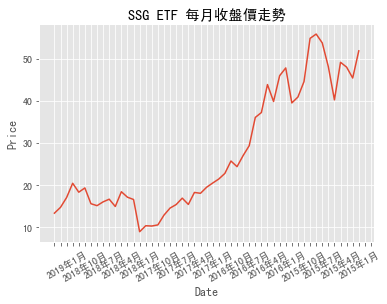

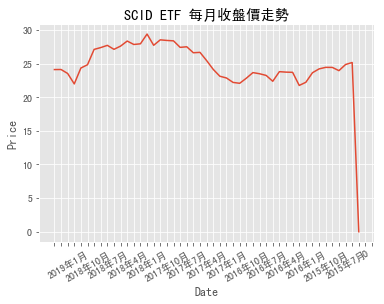

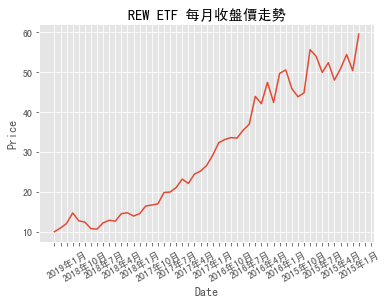

In [59]:
import matplotlib.pyplot as plt
import numpy as np

#set the style of the picture
plt.style.use('ggplot')

getdata = pd.read_excel("ETF_data.xls")
#getdata.set_index('date').plot()
#print(getdata.isnull().sum()) # check all the missing data
getdata = getdata.fillna("0") # replace null with "0"
#print(getdata)

plt.rcParams['font.sans-serif'] = ['simhei'] #set chinese word font

def plot(j):
    
    plt.figure() #plot a new one
    
    #set title
    plt.title(etf_name[j]+' ETF 每月收盤價走勢')

    #set label
    plt.xlabel('Date')
    plt.ylabel('Price')

    #set xticks interval so they won't overlap
    plt.xticks(rotation=30)
    ax = plt.gca()
    plt.xticks(np.arange(55), getdata['Date'+str(j)])

    for ind, label in enumerate(ax.xaxis.get_ticklabels()):
        if ind % 3 == 2:  # set the interval of the xticks
            label.set_visible(True)
        else:
            label.set_visible(False)
            
    d1 = getdata['Price'+str(j)] #deal with the missing data 
    getdata['Price'+str(j)] = d1[~getdata['Price6'].isin(["0"])] #get the data if it != "0"
    
    #plot the line chart
    plt.plot(getdata['Date'+str(j)], getdata['Price'+str(j)])
    
for i in range(len(etf_name)):
    plot(i)

plt.show() #show all the plots


參考網站
* [ICI](https://www.ici.org/research/stats) 
* [selenium爬蟲教學](https://michaelchen.tech/selenium/yahoo-finance-crawler/)
* [Yaho財經](https://hk.finance.yahoo.com/quote/XLK/history?period1=1426694400&period2=1552924800&interval=1d&filter=history&frequency=1d)
* [HTML解讀](https://ithelp.ithome.com.tw/articles/10191259)
* [擷取電影資料](https://medium.com/datainpoint/%E5%A6%82%E4%BD%95%E7%8D%B2%E5%8F%96%E8%B3%87%E6%96%99-%E6%93%B7%E5%8F%96%E7%B6%B2%E9%A0%81%E5%85%A7%E5%AE%B9-%E4%B8%8B-6eb75143c9fb)
* [selenium python文檔](https://selenium-python-zh.readthedocs.io/en/latest/locating-elements.html)
* [爬蟲突破封禁](https://kknews.cc/zh-tw/tech/mjqmg.html)

遇到問題及解決方法
* 目標網站拒絕連線-driver名稱錯誤
* 爬取table data無法定位-觀察HTML很重要
* 點擊按鈕失敗-有新視窗開啟時需要切換視窗才抓的到元素  
* 爬蟲過程一直跳出error-檢查網路，適時關切爬蟲情況(最好顧著)